<a href="https://colab.research.google.com/github/saurabhmathur96/Speech-to-Text-Engine/blob/master/timit_conditioned_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install soundfile

In [9]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import zipfile

zipfile.ZipFile('My Drive/darpa-timit-acousticphonetic-continuous-speech.zip').extractall('..')

In [0]:
from pathlib import Path
import soundfile as sf 
from tqdm.auto import tqdm


def read_speech(base):
  signals = []
  targets = []
  accents = []
  sexes = []
  base = Path(base)
  for i, accent in tqdm(enumerate(base.iterdir())):
    for speaker in accent.iterdir():
      for f in speaker.iterdir():
        if f.suffix == '.wav':
          signal, rate = sf.read(f)
          signals.append(signal)

          target_file = f.name.replace('.WAV.wav', '.TXT')
          target_path = speaker / target_file
          words = open(target_path).read().strip().split(' ')[2:]
          target = ' '.join(words).lower().replace('.', '').replace(',', '').replace(' -- ', ' ').replace('-', ' ').replace('?', '').replace('"', '').replace('!', '').replace(':', '').replace(';', '')
          targets.append(target)
          accents.append(i)
          sexes.append(['M', 'F'].index(speaker.name[0]))
  return signals, targets, accents, sexes


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
from tqdm.auto import trange, tqdm


class SpeechData(torch.utils.data.Dataset):
  def __init__(self, inputs, input_lengths, outputs, output_lengths):
    self.inputs = inputs
    self.input_lengths = torch.Tensor(input_lengths)
    self.outputs = outputs
    self.output_lengths = torch.Tensor(output_lengths)
    
    self.n = len(inputs)
  
  def __len__(self):
    return self.n
  
  def __getitem__(self, i):
    inp = self.inputs[i]
    inp_len = self.input_lengths[i]
    op = self.outputs[i]
    op_len = self.output_lengths[i]
    return inp, inp_len, op, op_len

#
# Training data
#
s, t, accents, sexes = read_speech('../data/TRAIN')
chars = set(''.join(t))
char2index = { c: i+2 for i, c in enumerate(chars) }
char2index['<'] = 0
char2index['>'] = 1
print (char2index)

inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y, a, s in tqdm(zip(s, t, accents, sexes), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  a = F.one_hot(torch.tensor([a]*len(inp)), num_classes=8).float()
  s = F.one_hot(torch.tensor([s]*len(inp)), num_classes=2).float()
  inp = torch.cat([inp, a, s], 1)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 

train_data = SpeechData(inputs, input_lengths, outputs, output_lengths)


#
# Test data
#
s, t, accents, sexes = read_speech('../data/TEST')
inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y, a, s in tqdm(zip(s, t, accents, sexes), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  a = F.one_hot(torch.tensor([a]*len(inp)), num_classes=8).float()
  s = F.one_hot(torch.tensor([s]*len(inp)), num_classes=2).float()
  inp = torch.cat([inp, a, s], 1)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 
test_data = SpeechData(inputs, input_lengths, outputs, output_lengths)

{'x': 2, 'u': 3, 'm': 4, 'k': 5, 'z': 6, 'e': 7, 'q': 8, 'f': 9, 'w': 10, 'g': 11, ' ': 12, 'o': 13, 'h': 14, 't': 15, "'": 16, 'c': 17, 'r': 18, 'v': 19, 's': 20, 'l': 21, 'j': 22, 'y': 23, 'n': 24, 'i': 25, 'd': 26, 'p': 27, 'a': 28, 'b': 29, '<': 0, '>': 1}


In [0]:
class SpeechNet(nn.Module):
  def __init__(self, device, input_size=513, output_size=len(char2index)+1, num_layers=2, hidden_size=128):
    self.device = device
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    super(SpeechNet, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    h = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    c = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    output, (h, c) = self.lstm(x, (h,c))
    # print (h.shape, c.shape)
    out = self.linear(output)
    return torch.nn.functional.log_softmax(out, 2)
  

def collate(batch):
  inp, inp_len, op, op_len = zip(*batch)
  inp = torch.nn.utils.rnn.pad_sequence(inp, batch_first=True, padding_value=len(char2index))
  inp_len = torch.stack(inp_len)
  op = torch.cat(op) # torch.nn.utils.rnn.pad_sequence(op, batch_first=True, padding_value=len(char2index))
  op_len = torch.stack(op_len)
  return inp, inp_len, op, op_len 


import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, collate_fn=collate)

In [28]:
from torch.autograd import Variable
from tqdm.auto import tqdm
import itertools


device = torch.device('cuda')

net = SpeechNet(device, input_size=523).to(device)
net.apply(weight_init)


criterion = nn.CTCLoss(blank=len(char2index), zero_infinity=True, reduction='mean').to(device) 
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-5)
losses = []
test_loss = []
for epoch in range(25):
  print (f'Epoch {epoch}:')
  for inp, inp_len, op, op_len in tqdm(train_loader):
    
    inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
    op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)

    optimizer.zero_grad()
    
    p = net(inp)
    
    loss = criterion(p.transpose(0,1), op, inp_len, op_len)
    # loss[loss == float("Inf")] = 0
    # print (loss.mean())
    
    loss = loss.mean()
    losses.append(loss.item())

    # torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
    loss.backward()
    optimizer.step()
  print ('train loss = ', np.mean(losses[::-1][:len(train_loader)]))
  
  
  with torch.no_grad():
    for inp, inp_len, op, op_len in tqdm(test_loader):
        
        inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
        op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)
        p = net(inp)
        
        loss = criterion(p.transpose(0,1), op, inp_len, op_len)
        
        loss = loss.mean()
        test_loss.append(loss.item())
    print ('test loss = ', np.mean(test_loss[::-1][:len(test_loader)]))

    '''
    index2char = dict(zip(char2index.values(), char2index.keys()))
    for pi in p:
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        if i < len(index2char):
          print (index2char[i], end = '')
      print ()
    '''

Epoch 0:


train loss =  3.240906352866186


test loss =  3.005361548176518
Epoch 1:


train loss =  2.9560941441418374


test loss =  2.881092142175745
Epoch 2:


train loss =  2.7997404483899677


test loss =  2.722328371471829
Epoch 3:


train loss =  2.6252993230950343


test loss =  2.5145062340630426
Epoch 4:


train loss =  2.4102494194083017


test loss =  2.3104502624935574
Epoch 5:


train loss =  2.2398535911351036


test loss =  2.1631118103309914
Epoch 6:


train loss =  2.1029426839253675


test loss =  2.062463879585266
Epoch 7:


train loss =  1.9952181071451265


test loss =  1.9550784340611211
Epoch 8:


train loss =  1.8978890866449434


test loss =  1.9021792853320088
Epoch 9:


train loss =  1.8200636171314815


test loss =  1.8172056145138211
Epoch 10:


train loss =  1.759183597891298


test loss =  1.785991730513396
Epoch 11:


train loss =  1.7080685292204765


test loss =  1.7385819443949946
Epoch 12:


train loss =  1.6623858507365397


test loss =  1.7010775098094233
Epoch 13:


train loss =  1.6190862394359014


test loss =  1.6782102099171392
Epoch 14:


train loss =  1.5922542777779984


test loss =  1.646121903702065
Epoch 15:


train loss =  1.5604890601275718


test loss =  1.6289022631115384
Epoch 16:


train loss =  1.5253156390908647


test loss =  1.6110844523818404
Epoch 17:


train loss =  1.5260091775084195


test loss =  1.6071658002005682
Epoch 18:


train loss =  1.4878592736100498


test loss =  1.5891927745607164
Epoch 19:


train loss =  1.4636746334703001


test loss =  1.5677359369066026
Epoch 20:


train loss =  1.4354016503242597


test loss =  1.5608236613097015
Epoch 21:


train loss =  1.4156374188318646


test loss =  1.5383549531300862
Epoch 22:


train loss =  1.3974893680990559


test loss =  1.532736645804511
Epoch 23:


train loss =  1.3844236004842472


test loss =  1.534598708152771
Epoch 24:


train loss =  1.3606976074715182


test loss =  1.5233032438490126


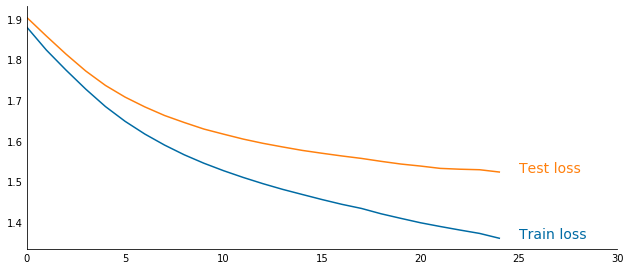

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

plt.xlim(0, len(tr)+5)
tr = [np.mean(losses[start:start+len(losses)])  for start in range(0, len(losses), len(train_loader))]
plt.plot(tr, color=tableau20blind[0])


te = [np.mean(test_loss[start:start+len(test_loss)]) for start in range(0, len(test_loss), len(test_loader))]
plt.plot(te, color=tableau20blind[1])

plt.text( len(tr),tr[-1],   'Train loss', color=tableau20blind[0], fontsize=14)
plt.text( len(te),te[-1], 'Test loss', color=tableau20blind[1], fontsize=14)

    

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.tight_layout(pad=5)
plt.gca().tick_params(axis='both', length=0)

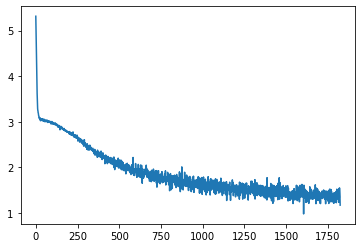

In [30]:
plt.plot(losses)

In [64]:
import itertools
with torch.no_grad():
  for inp, inp_len, op, op_len in test_loader:
    index2char = dict(zip(char2index.values(), char2index.keys()))
    inp, inp_len = inp.float().to(device), inp_len.long().to(device)
    op, op_len = op.long().to(device), op_len.long().to(device)

      

    p = net(inp)
    start = 0
    for pi, o in zip(p, op_len):
      
      
      print (''.join(index2char[i] for i in op[start:start+o].cpu().numpy()))
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        
        if i < len(index2char):
          print (index2char[i], end = '')
      print ('\n')
      start += o
    break

<his captain was thin and haggard and his beautiful boots were worn and shabby>
<iss captin oatennan h hager binteisetefol bheswor woarding chadbe> 

<pretty soon a woman came along carrying a folded umbrella as a walking stick>
<preasi aor an tamwan cher af floldem barlars a wacincte>

<he says he'll be here on the one o'clock plane>
<hes sesobeteral he mo aoktlan> 

<put on his old brown corduroy coat and it was already soaked>
<the ot as lo grn coro co mel ori so>

<you certainly can't expect the infield to do any better than it did last year>
< sher a canpacke an tel dean a a ler>

<combine all the ingredients in a large bowl>
<com bon ol ean greiansi llor pl>

<bob papered over the living room murals>
<o papere eo h ha ligi r erals>

<call an ambulance for medical assistance>
<coor av relns for meata cosites> 

<jane may earn more money by working hard>
<she raearn or mobar workon or>

<when suitably lighted what would it look like>
<wen sudo dhlla a wo wra lacl>

<the gunman kept